In [1]:
import sys
import os
import numpy as np
import pandas as pd

import h5py

import matplotlib.pyplot as plt

from scipy.stats import spearmanr, pearsonr

from scipy.ndimage import gaussian_filter1d

import seaborn as sns

import matplotlib.cm as cm
import matplotlib.colors as colors

import matplotlib as mpl
from matplotlib.text import TextPath
from matplotlib.patches import PathPatch, Rectangle
from matplotlib.font_manager import FontProperties
from matplotlib import gridspec
from matplotlib.ticker import FormatStrFormatter

#Helper function to draw a letter at a given position
def dna_letter_at(letter, x, y, yscale=1, ax=None, color=None, alpha=1.0):

    #Define letter heights and colors
    fp = FontProperties(family="DejaVu Sans", weight="bold")
    globscale = 1.35
    LETTERS = {	"T" : TextPath((-0.305, 0), "T", size=1, prop=fp),
                "G" : TextPath((-0.384, 0), "G", size=1, prop=fp),
                "A" : TextPath((-0.35, 0), "A", size=1, prop=fp),
                "C" : TextPath((-0.366, 0), "C", size=1, prop=fp),
                "UP" : TextPath((-0.488, 0), '$\\Uparrow$', size=1, prop=fp),
                "DN" : TextPath((-0.488, 0), '$\\Downarrow$', size=1, prop=fp),
                "(" : TextPath((-0.25, 0), "(", size=1, prop=fp),
                "." : TextPath((-0.125, 0), "-", size=1, prop=fp),
                ")" : TextPath((-0.1, 0), ")", size=1, prop=fp)}
    COLOR_SCHEME = {'G': 'orange',#'orange', 
                    'A': 'green',#'red', 
                    'C': 'blue',#'blue', 
                    'T': 'red',#'darkgreen',
                    'UP': 'green', 
                    'DN': 'red',
                    '(': 'black',
                    '.': 'black', 
                    ')': 'black'}


    text = LETTERS[letter]

    #Choose color
    chosen_color = COLOR_SCHEME[letter]
    if color is not None :
        chosen_color = color

    #Draw letter onto axis
    t = mpl.transforms.Affine2D().scale(1*globscale, yscale*globscale) + \
        mpl.transforms.Affine2D().translate(x,y) + ax.transData
    p = PathPatch(text, lw=0, fc=chosen_color, alpha=alpha, transform=t)
    if ax != None:
        ax.add_artist(p)
    
    return p

#Function to plot sequence logo
def plot_seq_scores(importance_scores, figsize=(16, 2), plot_y_ticks=True, y_min=None, y_max=None, save_figs=False, fig_name="default") :

    importance_scores = importance_scores.T

    fig = plt.figure(figsize=figsize)
    
    ref_seq = ""
    
    #Loop over reference sequence letters
    for j in range(importance_scores.shape[1]) :
        argmax_nt = np.argmax(np.abs(importance_scores[:, j]))
        
        if argmax_nt == 0 :
            ref_seq += "A"
        elif argmax_nt == 1 :
            ref_seq += "C"
        elif argmax_nt == 2 :
            ref_seq += "G"
        elif argmax_nt == 3 :
            ref_seq += "T"

    ax = plt.gca()
    
    #Loop over reference sequence letters and draw
    for i in range(0, len(ref_seq)) :
        mutability_score = np.sum(importance_scores[:, i])
        color = None
        dna_letter_at(ref_seq[i], i + 0.5, 0, mutability_score, ax, color=color)
    
    plt.sca(ax)
    plt.xticks([], [])
    plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    
    plt.xlim((0, len(ref_seq)))
    
    #plt.axis('off')
    
    if plot_y_ticks :
        plt.yticks(fontsize=12)
    else :
        plt.yticks([], [])
    
    #Set axis limits
    if y_min is not None and y_max is not None :
        print(" - y_min = " + str(round(y_min, 8)))
        print(" - y_max = " + str(round(y_max, 8)))
        
        plt.ylim(y_min, y_max)
    elif y_min is not None :
        plt.ylim(y_min)
    else :
        print(" - y_min = " + str(round(np.min(importance_scores) - 0.1 * np.max(np.abs(importance_scores)), 8)))
        print(" - y_max = " + str(round(np.max(importance_scores) + 0.1 * np.max(np.abs(importance_scores)), 8)))
        
        plt.ylim(
            np.min(importance_scores) - 0.1 * np.max(np.abs(importance_scores)),
            np.max(importance_scores) + 0.1 * np.max(np.abs(importance_scores))
        )
    
    plt.axhline(y=0., color='black', linestyle='-', linewidth=1)

    #for axis in fig.axes :
    #    axis.get_xaxis().set_visible(False)
    #    axis.get_yaxis().set_visible(False)

    plt.tight_layout()

    if save_figs :
        plt.savefig(fig_name + ".png", transparent=True, dpi=300)
        plt.savefig(fig_name + ".eps")

    plt.show()


In [3]:
#Load gene dataframe and select tissue

tissue = 'brain_cortex'

top_n = 200

gene_df = pd.read_csv("/home/jlinder/seqnn/data/diff_expr/gtex_diff_expr_log2fc_5k.csv", sep='\t')
gene_df = gene_df.query("tissue == '" + str(tissue) + "'").copy().reset_index(drop=True)
gene_df = gene_df.drop(columns=['Unnamed: 0'])

#Select top N
gene_df = gene_df.iloc[:top_n].copy().reset_index(drop=True)

print("len(gene_df) = " + str(len(gene_df)))

#Get list of gene for tissue
tissue_genes = gene_df['gene_base'].values.tolist()

print("len(tissue_genes) = " + str(len(tissue_genes)))


len(gene_df) = 200
len(tissue_genes) = 200


In [4]:
#Load ISMs for the selected set of GTEx tissues

import gc

gtex_tissues = ['blood', 'brain', 'esophagus', 'liver', 'muscle']
gtex_tissue_targets = [[0], [1], [2], [3], [4]]
gtex_h5s = [
    'scores_v2/gtex_brain_log2fc_ism_aggr_f0c0.h5',
    'scores_v2/gtex_brain_log2fc_ism_aggr_f0c0.h5',
    'scores_v2/gtex_brain_log2fc_ism_aggr_f0c0.h5',
    'scores_v2/gtex_brain_log2fc_ism_aggr_f0c0.h5',
    'scores_v2/gtex_brain_log2fc_ism_aggr_f0c0.h5',
]

ism_seqs = None
ism_starts = None
ism_ends = None

all_isms = []

#Loop over h5 score files
for gtex_i, gtex_h5 in enumerate(gtex_h5s) :
    
    print("h5 = '" + gtex_h5 + "'")

    score_file = h5py.File(gtex_h5, 'r')

    #Get scores and onehots
    isms = np.mean(score_file['isms'][()][..., gtex_tissue_targets[gtex_i]], axis=-1)
    ism_seqs = score_file['seqs'][()]

    ism_starts = np.array(score_file['ism_start'][()])
    ism_ends = np.array(score_file['ism_end'][()])

    genes = score_file['gene'][()]
    genes = np.array([genes[j].decode().split(".")[0] for j in range(genes.shape[0])])
    
    gene_dict = {gene : gene_i for gene_i, gene in enumerate(genes.tolist())}

    #Get index of rows to keep
    keep_index = []
    for tissue_gene in tissue_genes :
        keep_index.append(gene_dict[tissue_gene])

    #Filter/sub-select data
    isms = isms[keep_index, ...]
    ism_seqs = ism_seqs[keep_index, ...]
    ism_starts = ism_starts[keep_index]
    ism_ends = ism_ends[keep_index]

    #Input-gate the scores
    isms = isms * ism_seqs
    
    all_isms.append(isms[None, ...])

    #Collect garbage
    gc.collect()

#Collect final scores
isms = np.concatenate(all_isms, axis=0)

print("isms.shape = " + str(isms.shape) + " (final)")

score_file = None

#Collect garbage
gc.collect()


h5 = 'scores_v2/gtex_brain_log2fc_ism_aggr_f0c0.h5'
h5 = 'scores_v2/gtex_brain_log2fc_ism_aggr_f0c0.h5'
h5 = 'scores_v2/gtex_brain_log2fc_ism_aggr_f0c0.h5'
h5 = 'scores_v2/gtex_brain_log2fc_ism_aggr_f0c0.h5'
h5 = 'scores_v2/gtex_brain_log2fc_ism_aggr_f0c0.h5'
isms.shape = (5, 200, 192, 4) (final)


0

In [5]:
#Load grad scores for the selected set of GTEx tissues

import gc

gtex_tissues = ['blood', 'brain', 'esophagus', 'liver', 'muscle']
gtex_h5s = [
    'scores_v2/gtex_blood_log2fc_undo_clip_scores_f0c0.h5',
    'scores_v2/gtex_brain_log2fc_undo_clip_scores_f0c0.h5',
    'scores_v2/gtex_esophagus_log2fc_undo_clip_scores_f0c0.h5',
    'scores_v2/gtex_liver_log2fc_undo_clip_scores_f0c0.h5',
    'scores_v2/gtex_muscle_log2fc_undo_clip_scores_f0c0.h5',
]

seqs = None
strands = None
chrs = None
starts = None
ends = None
genes = None

all_scores = []

#Loop over h5 score files
for gtex_h5 in gtex_h5s :
    
    print("h5 = '" + gtex_h5 + "'")

    score_file = h5py.File(gtex_h5, 'r')

    #Get scores and onehots
    scores = score_file['grads'][()][..., 0]
    seqs = score_file['seqs'][()]

    #Get auxiliary information
    strands = score_file['strand'][()]
    strands = np.array([strands[j].decode() for j in range(strands.shape[0])])

    chrs = score_file['chr'][()]
    chrs = np.array([chrs[j].decode() for j in range(chrs.shape[0])])

    starts = np.array(score_file['start'][()])
    ends = np.array(score_file['end'][()])

    genes = score_file['gene'][()]
    genes = np.array([genes[j].decode().split(".")[0] for j in range(genes.shape[0])])
    
    gene_dict = {gene : gene_i for gene_i, gene in enumerate(genes.tolist())}

    #Get index of rows to keep
    keep_index = []
    for tissue_gene in tissue_genes :
        keep_index.append(gene_dict[tissue_gene])

    #Filter/sub-select data
    scores = scores[keep_index, ...]
    seqs = seqs[keep_index, ...]
    strands = strands[keep_index]
    chrs = chrs[keep_index]
    starts = starts[keep_index]
    ends = ends[keep_index]
    genes = genes[keep_index]

    #Input-gate the scores
    scores = scores * seqs
    
    #Slice out same window as ISMs were computed over
    scores_new = np.zeros((scores.shape[0], ism_ends[0]-ism_starts[0], 4))
    seqs_new = np.zeros((scores.shape[0], ism_ends[0]-ism_starts[0], 4), dtype=bool)
    for gi in range(scores.shape[0]) :
        scores_new[gi, ...] = scores[gi, ism_starts[gi]:ism_ends[gi], :]
        seqs_new[gi, ...] = seqs[gi, ism_starts[gi]:ism_ends[gi], :]
    
    scores = scores_new
    seqs = seqs_new
    
    all_scores.append(scores[None, ...])

    #Collect garbage
    gc.collect()

#Collect final scores
scores = np.concatenate(all_scores, axis=0)

print("scores.shape = " + str(scores.shape) + " (final)")

score_file = None

#Collect garbage
gc.collect()


h5 = 'scores_v2/gtex_blood_log2fc_undo_clip_scores_f0c0.h5'
h5 = 'scores_v2/gtex_brain_log2fc_undo_clip_scores_f0c0.h5'
h5 = 'scores_v2/gtex_esophagus_log2fc_undo_clip_scores_f0c0.h5'
h5 = 'scores_v2/gtex_liver_log2fc_undo_clip_scores_f0c0.h5'
h5 = 'scores_v2/gtex_muscle_log2fc_undo_clip_scores_f0c0.h5'
scores.shape = (5, 200, 192, 4) (final)


0

-- 0 (+) --
ENSG00000006116
chr16:24063923-24588211


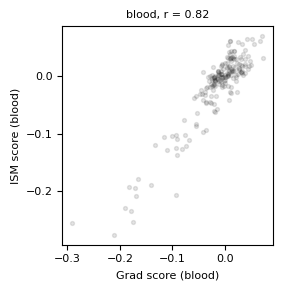

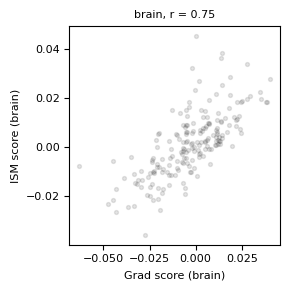

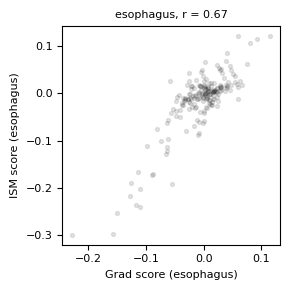

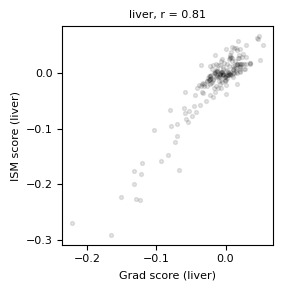

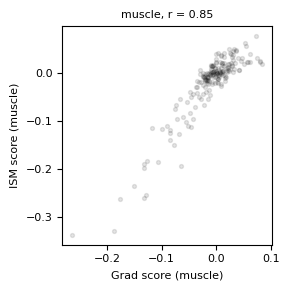

blood


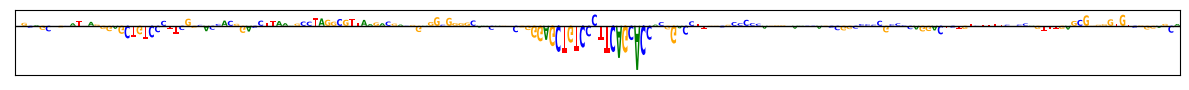

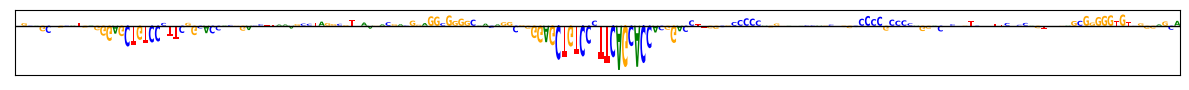

brain


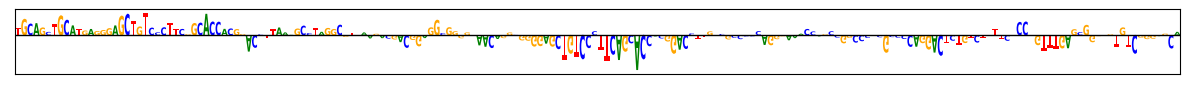

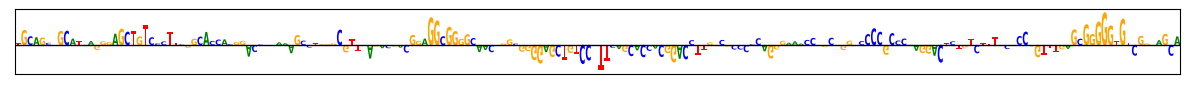

esophagus


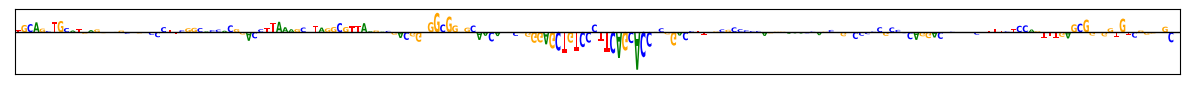

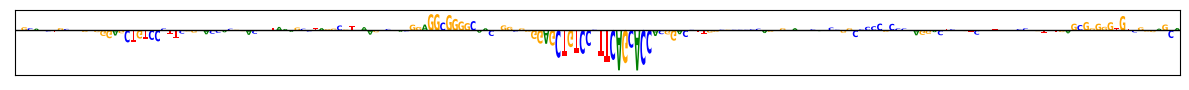

liver


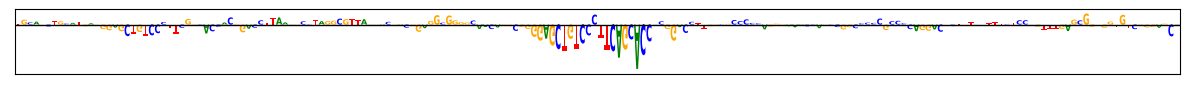

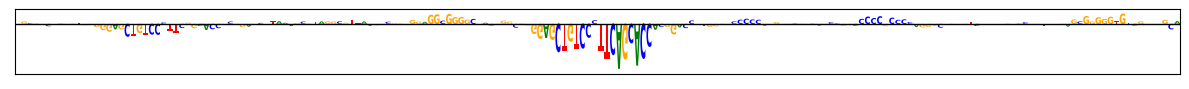

muscle


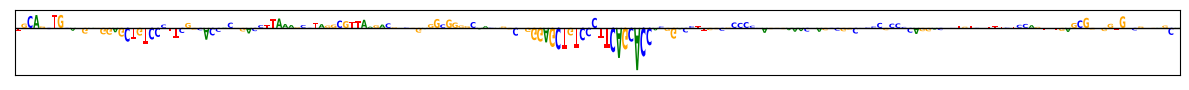

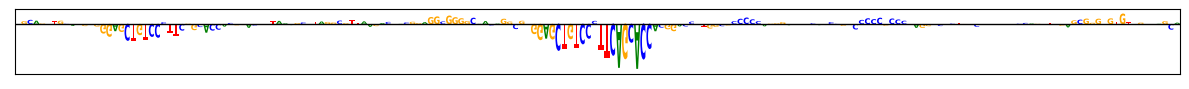

-- 1 (-) --
ENSG00000165643
chr9:135433922-135958210


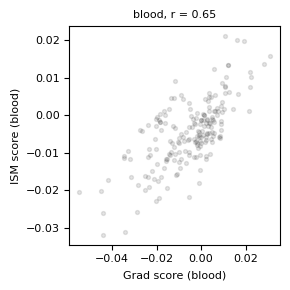

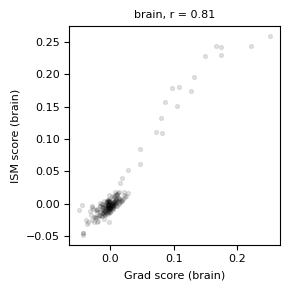

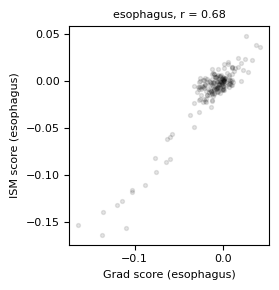

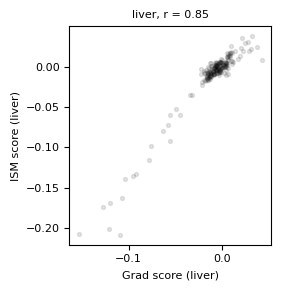

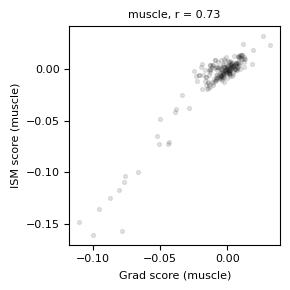

blood


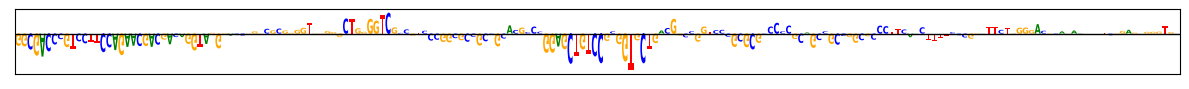

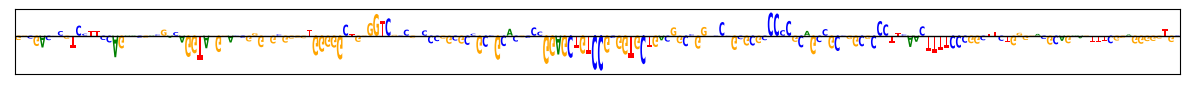

brain


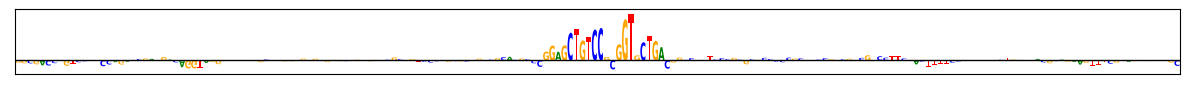

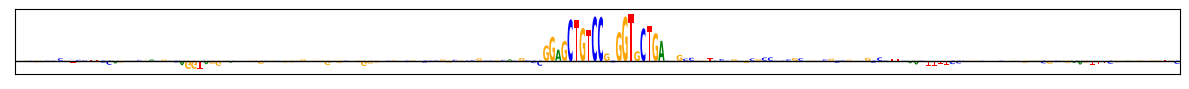

esophagus


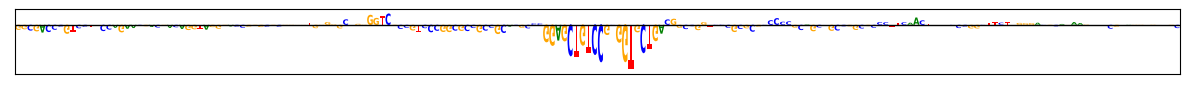

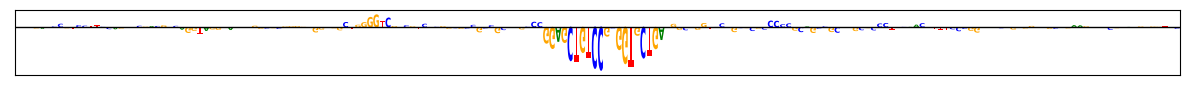

liver


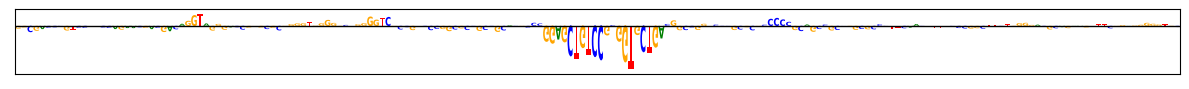

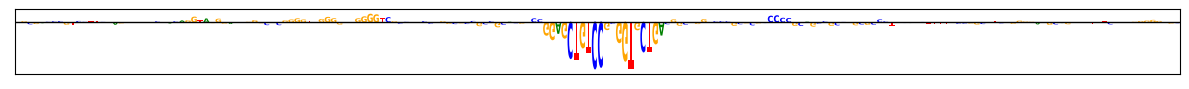

muscle


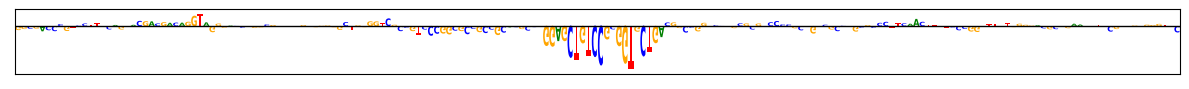

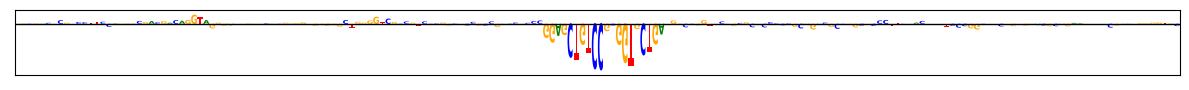

-- 2 (-) --
ENSG00000188674
chr2:207912736-208437024


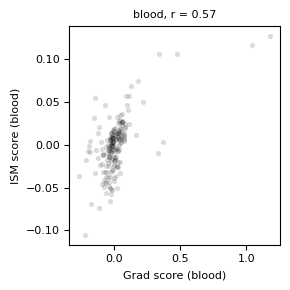

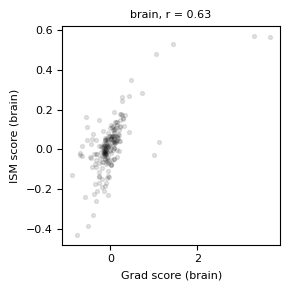

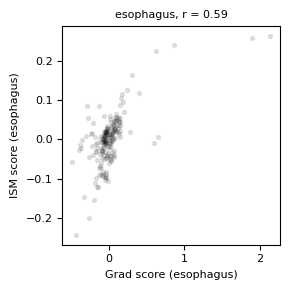

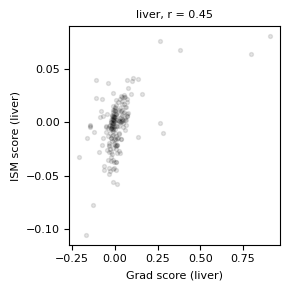

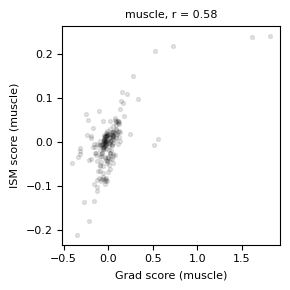

blood


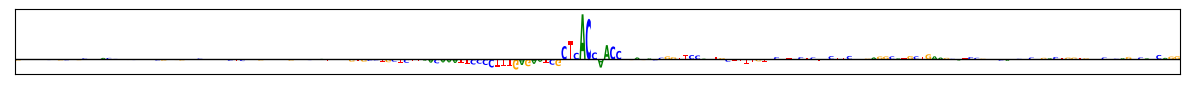

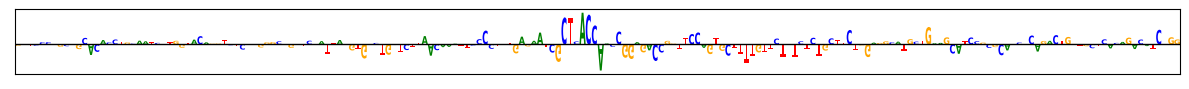

brain


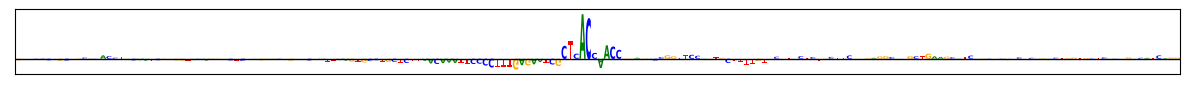

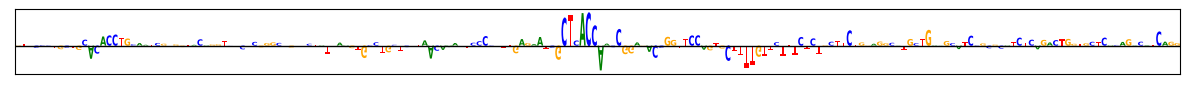

esophagus


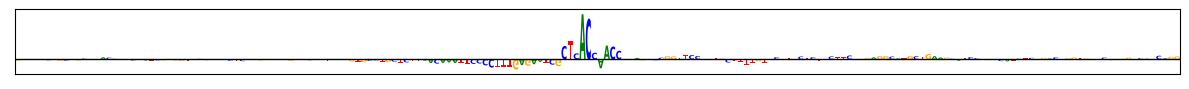

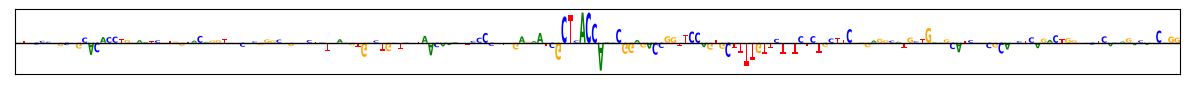

liver


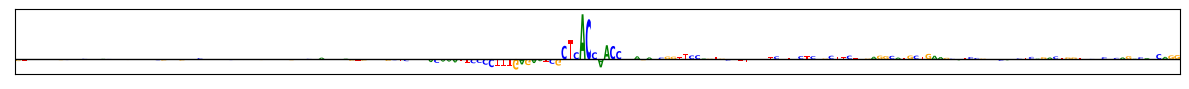

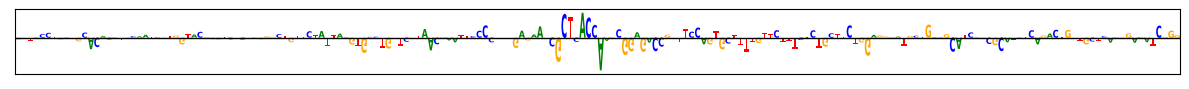

muscle


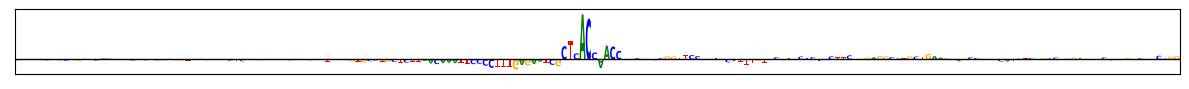

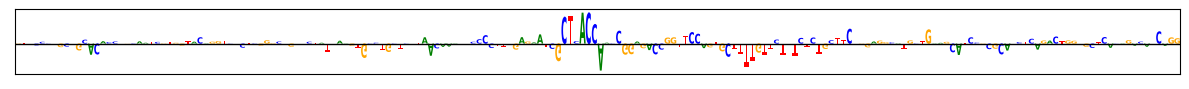

-- 3 (+) --
ENSG00000022355
chr5:161627376-162151664


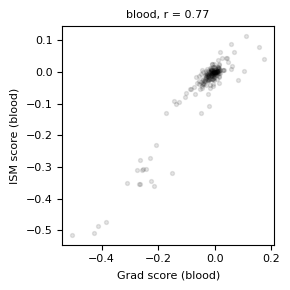

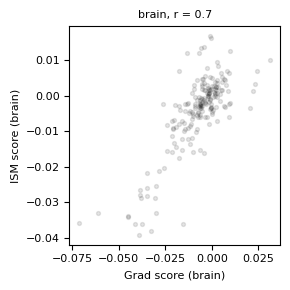

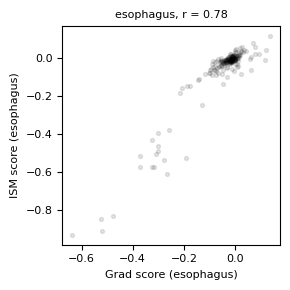

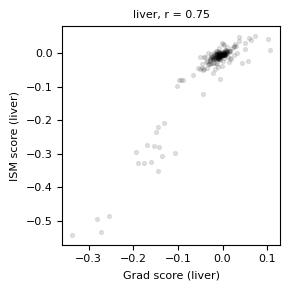

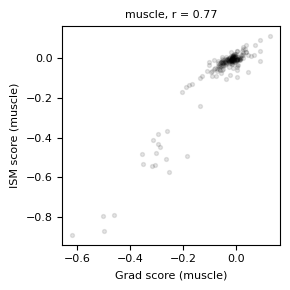

blood


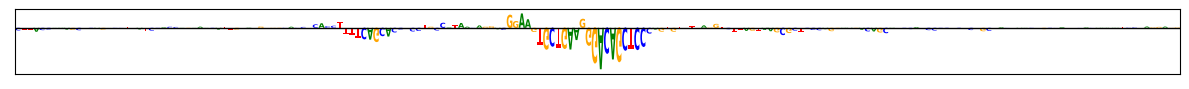

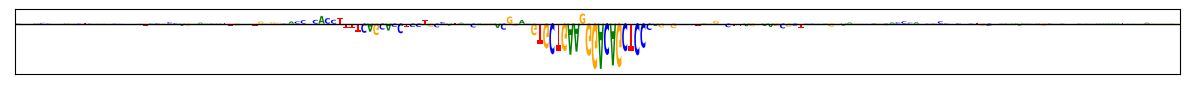

brain


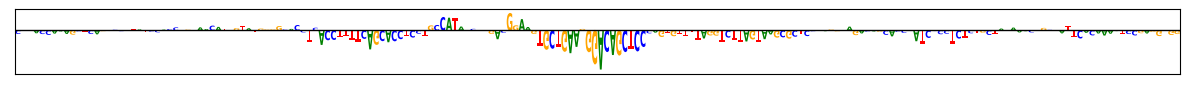

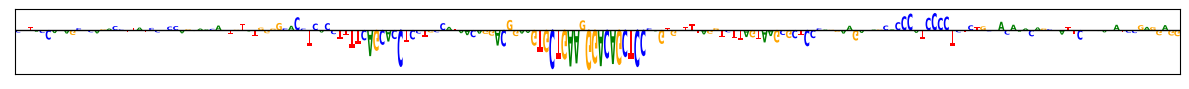

esophagus


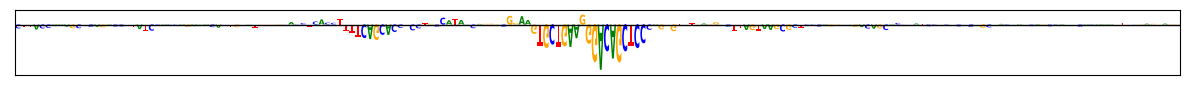

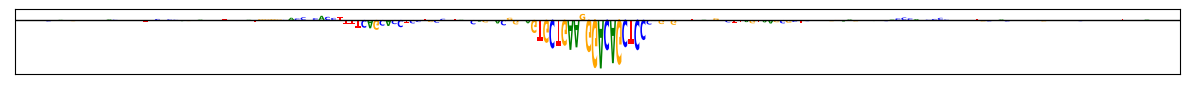

liver


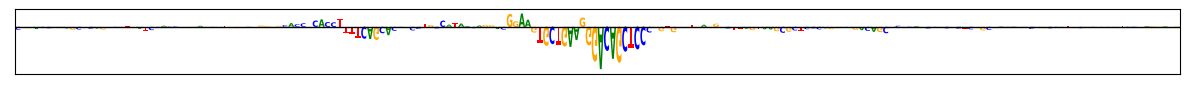

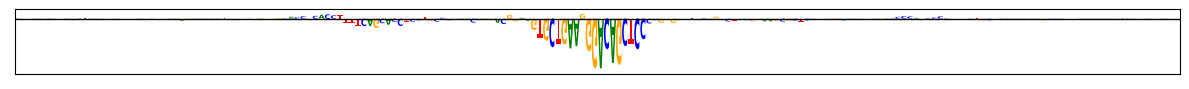

muscle


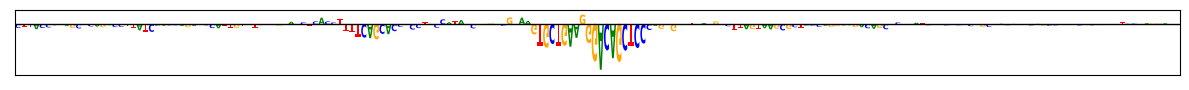

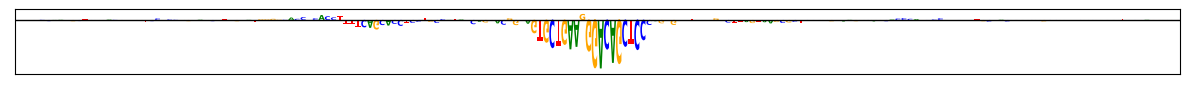

-- 4 (-) --
ENSG00000164076
chr3:49598095-50122383


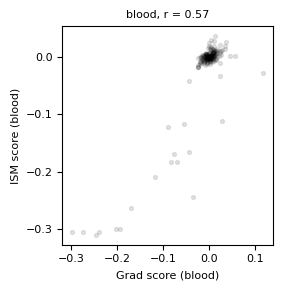

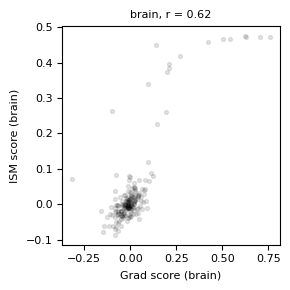

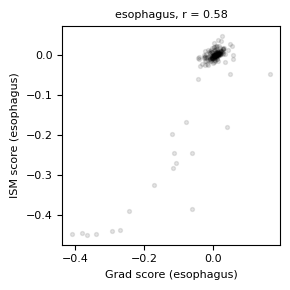

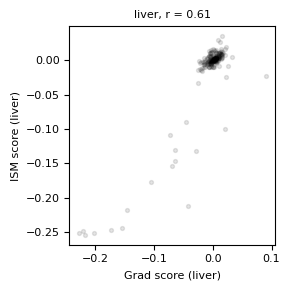

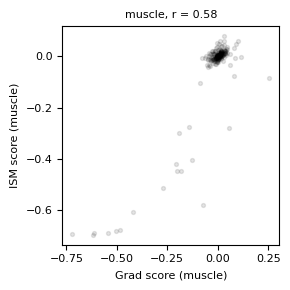

blood


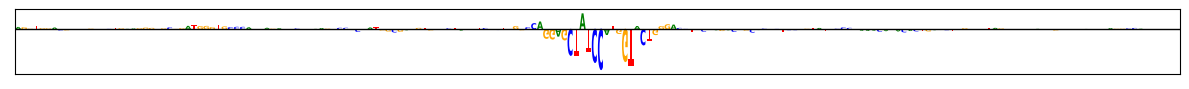

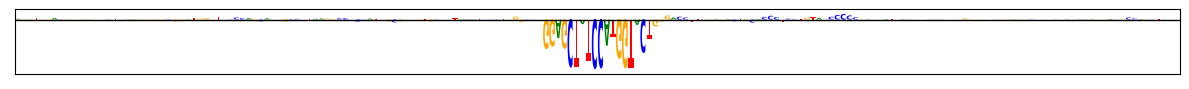

brain


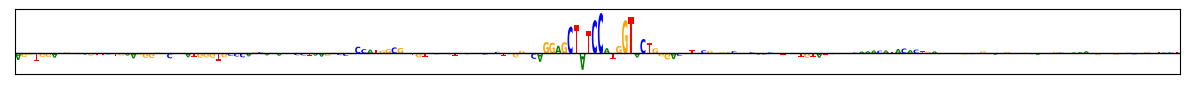

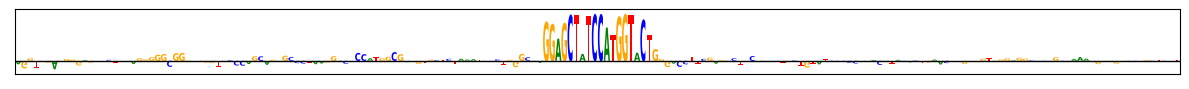

esophagus


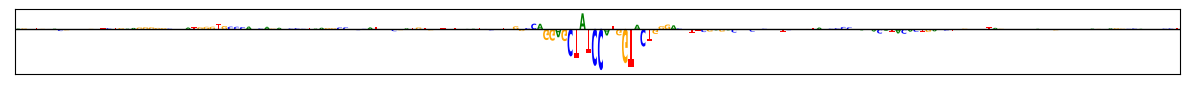

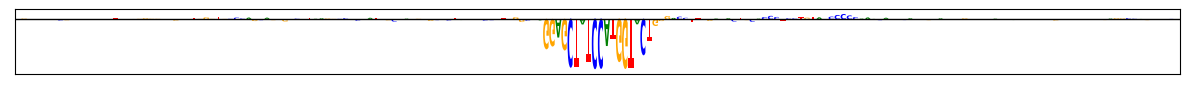

liver


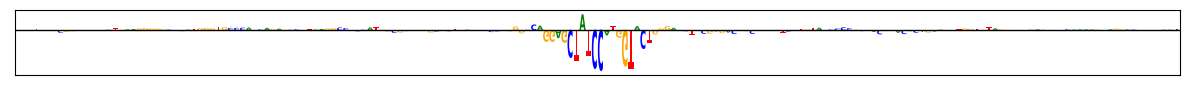

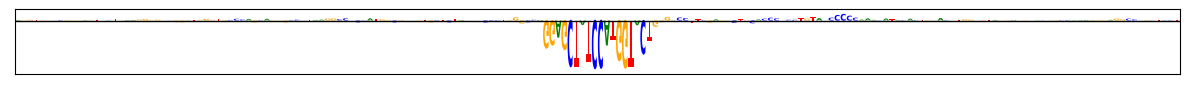

muscle


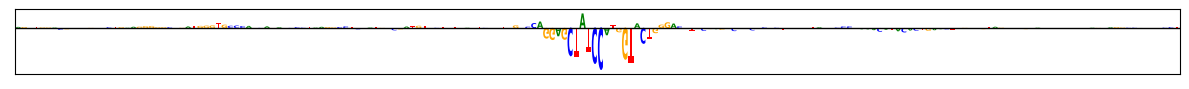

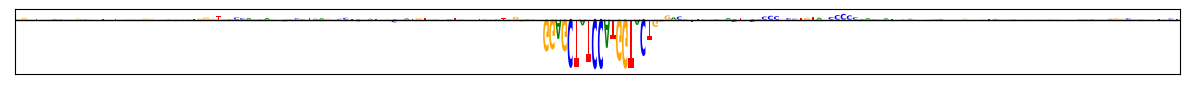

-- 5 (+) --
ENSG00000136535
chr2:161160006-161684294


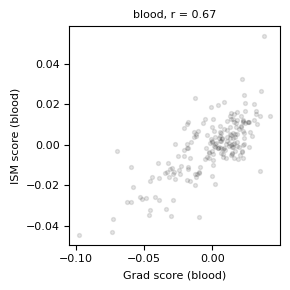

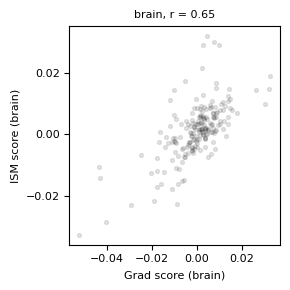

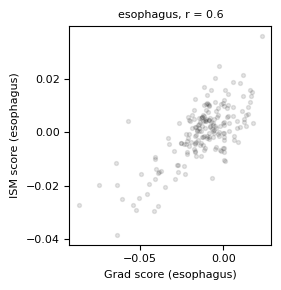

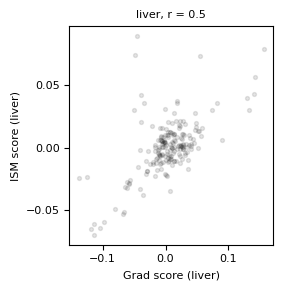

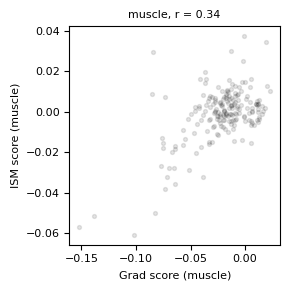

blood


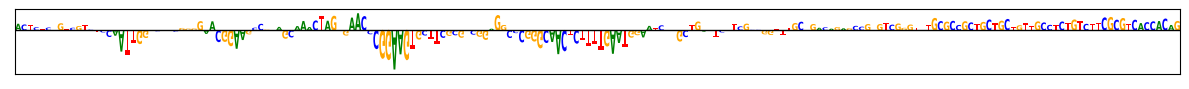

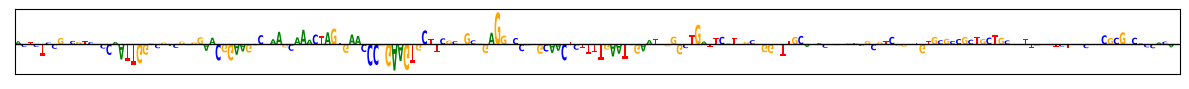

brain


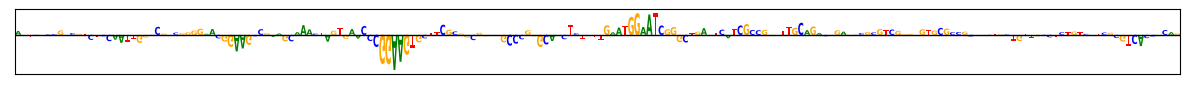

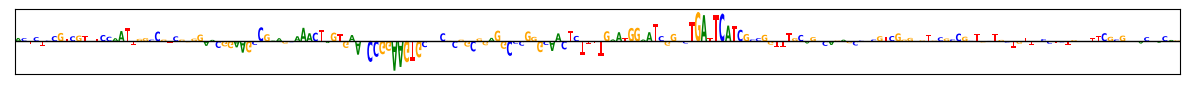

esophagus


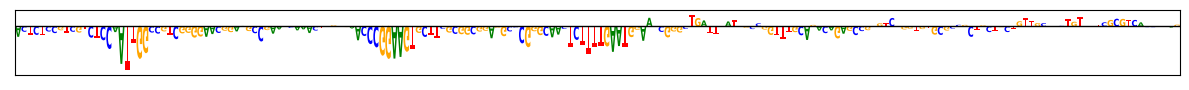

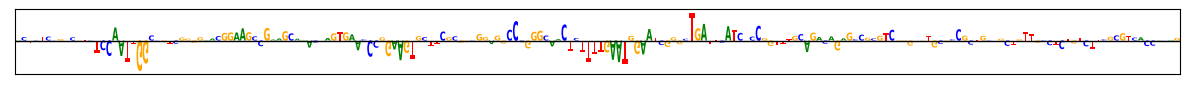

liver


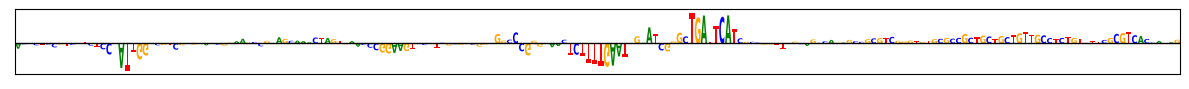

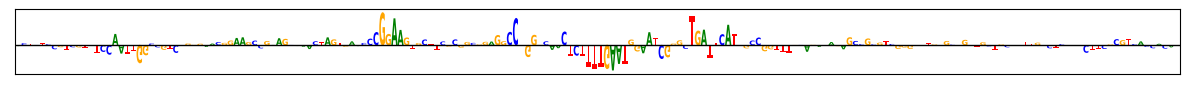

muscle


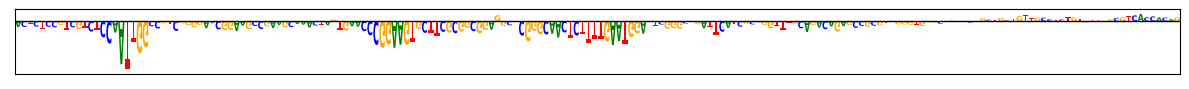

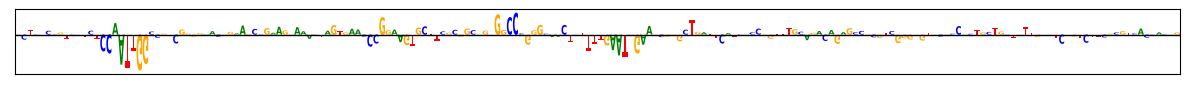

-- 6 (+) --
ENSG00000176884
chr9:136896841-137421129


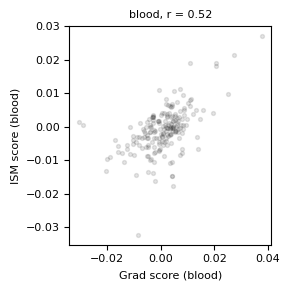

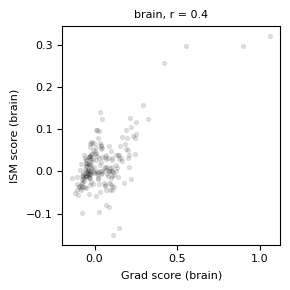

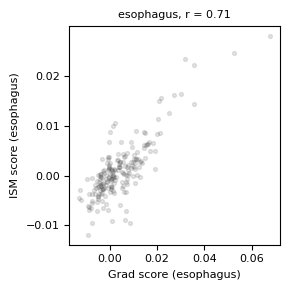

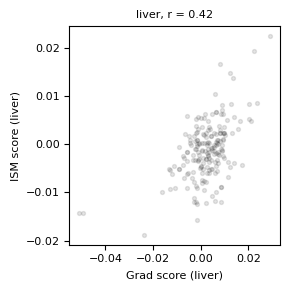

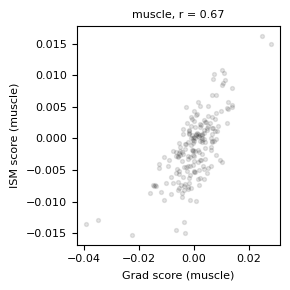

blood


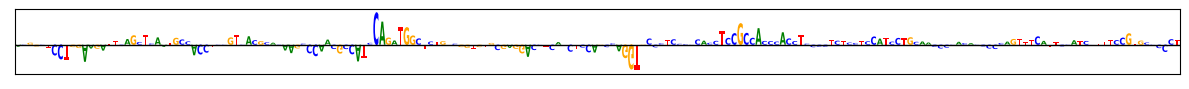

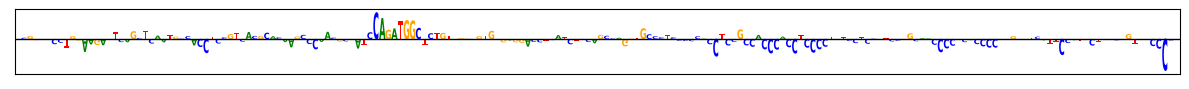

brain


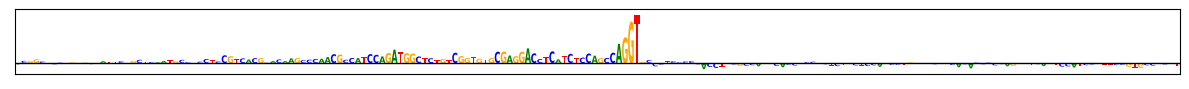

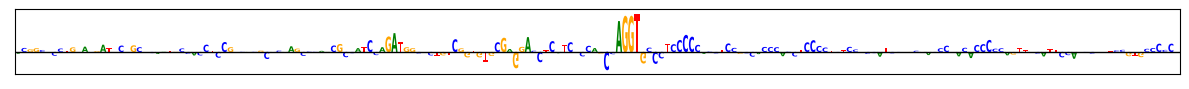

esophagus


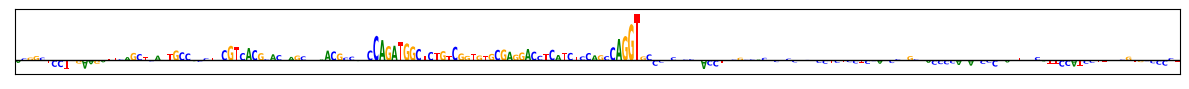

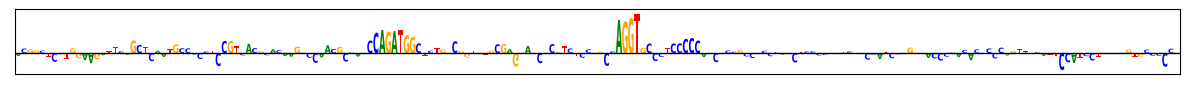

liver


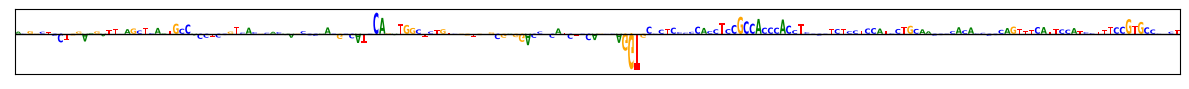

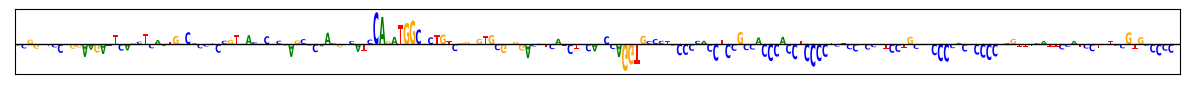

muscle


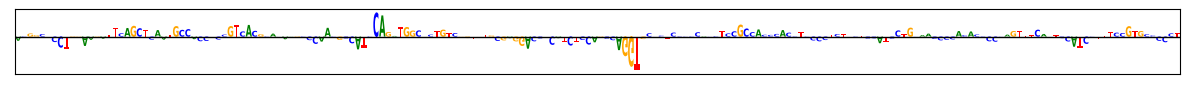

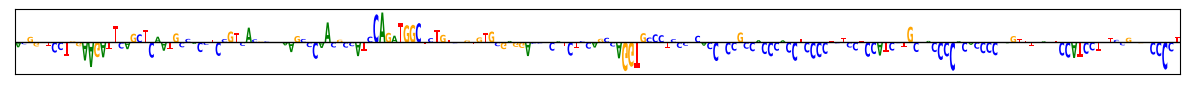

-- 7 (+) --
ENSG00000162728
chr1:159825536-160349824


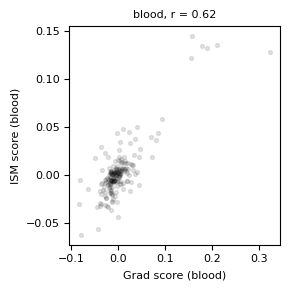

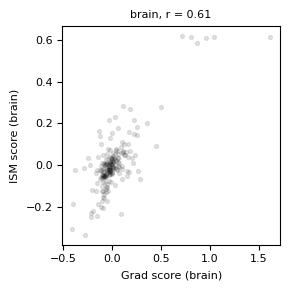

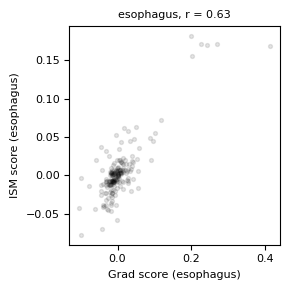

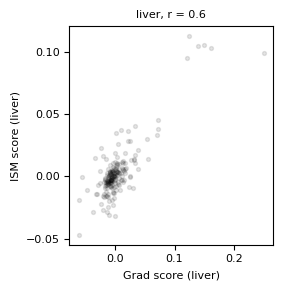

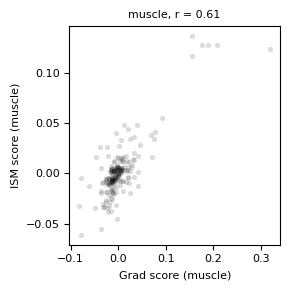

blood


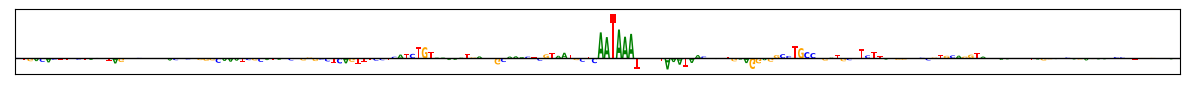

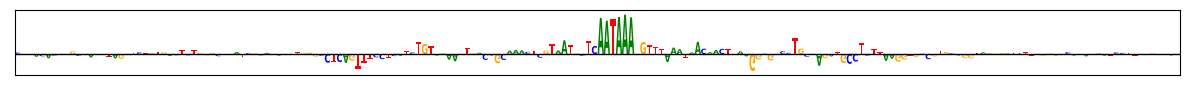

brain


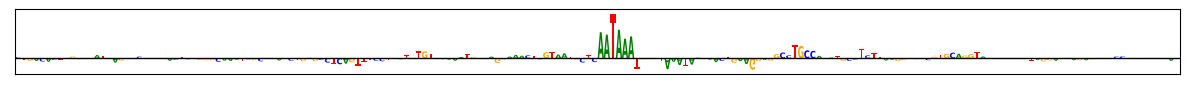

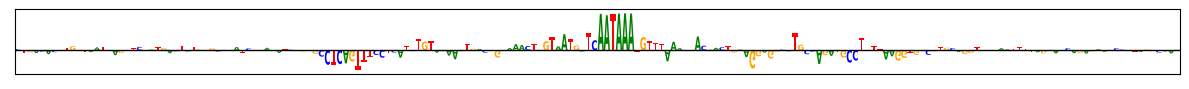

esophagus


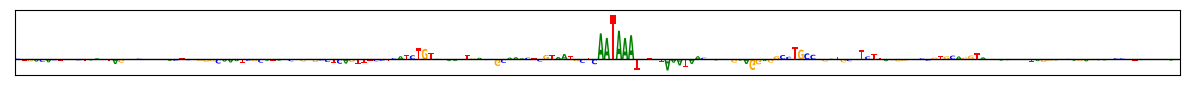

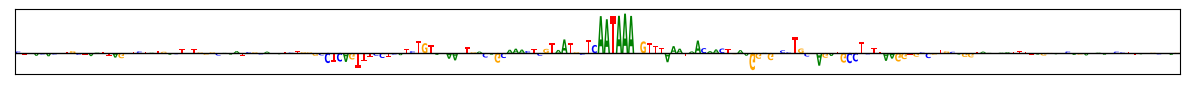

liver


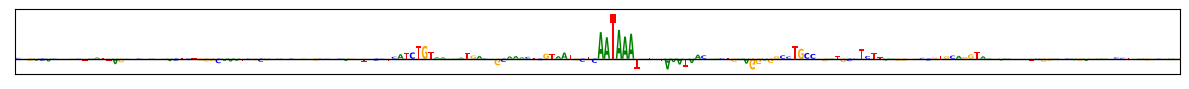

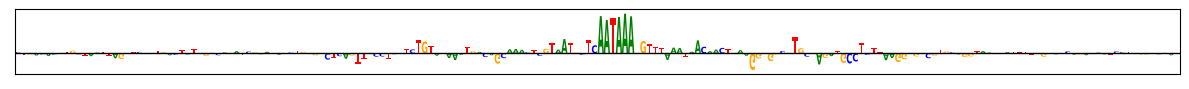

muscle


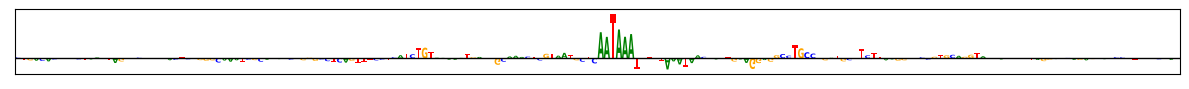

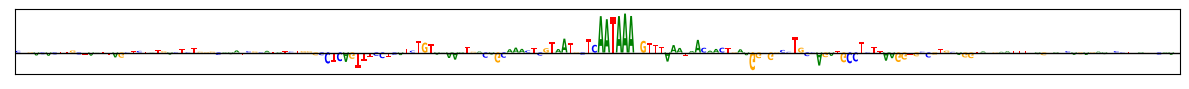

-- 8 (+) --
ENSG00000130287
chr19:18974967-19499255


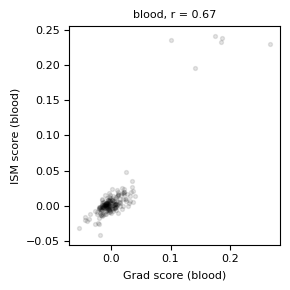

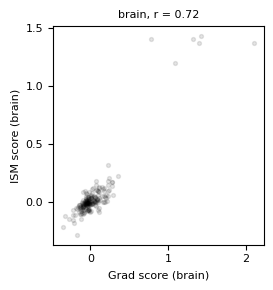

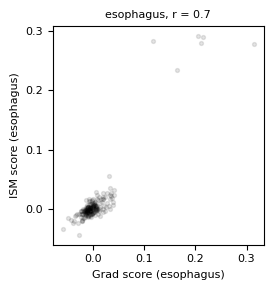

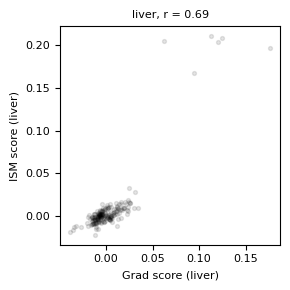

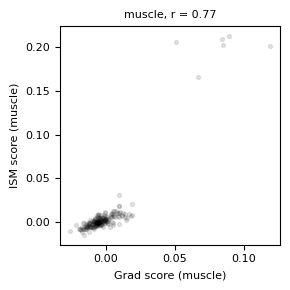

blood


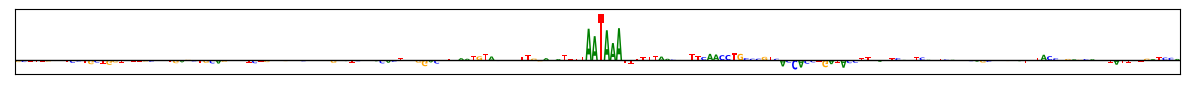

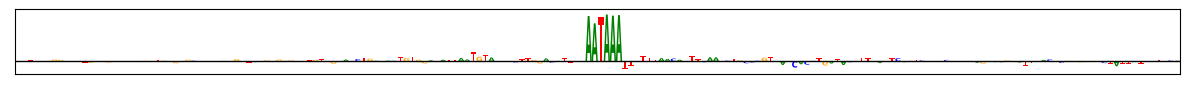

brain


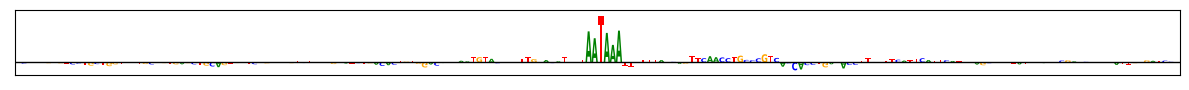

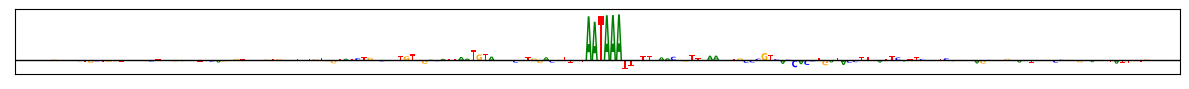

esophagus


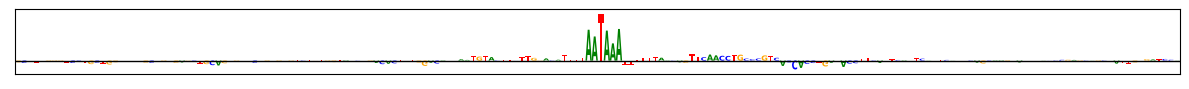

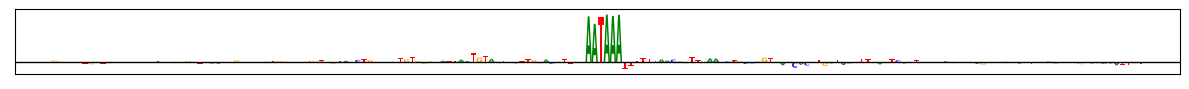

liver


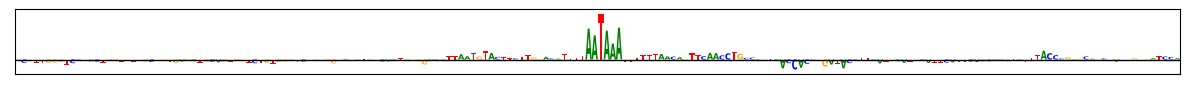

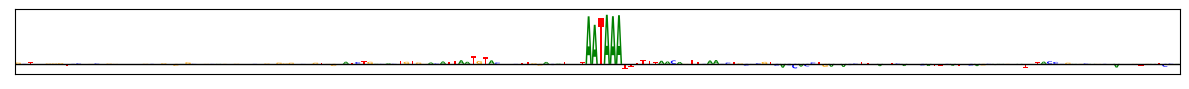

muscle


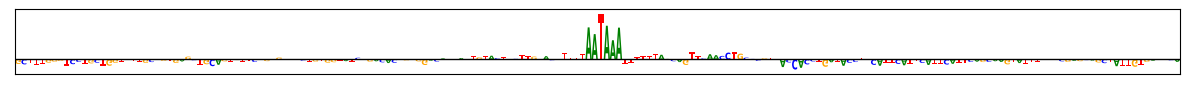

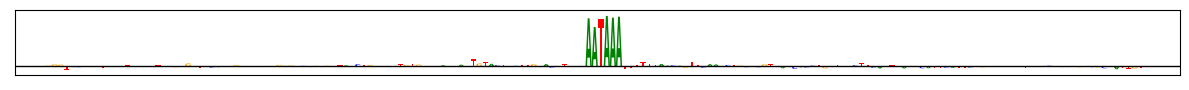

-- 9 (-) --
ENSG00000164600
chr7:31076388-31600676


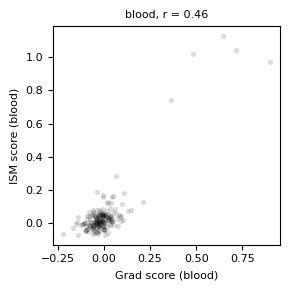

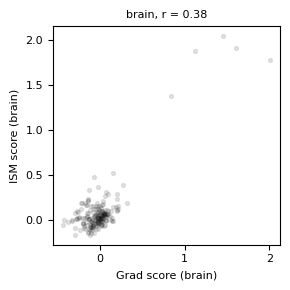

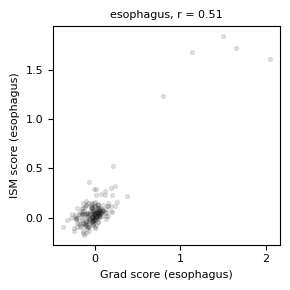

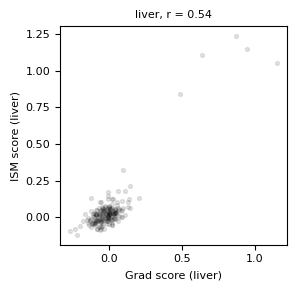

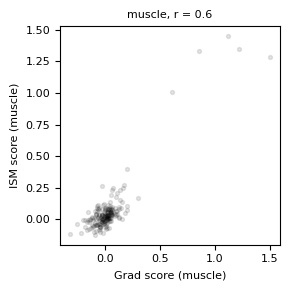

blood


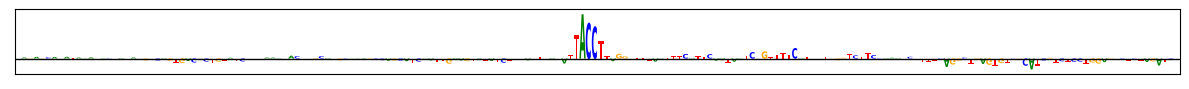

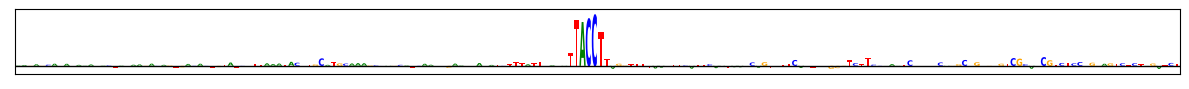

brain


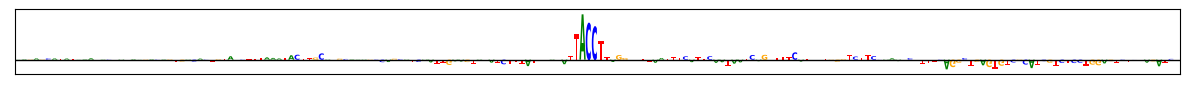

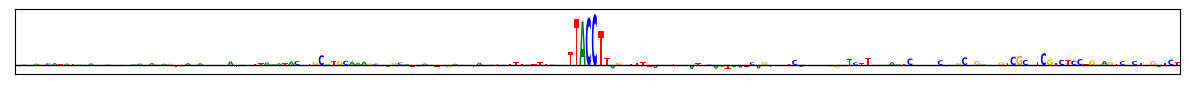

esophagus


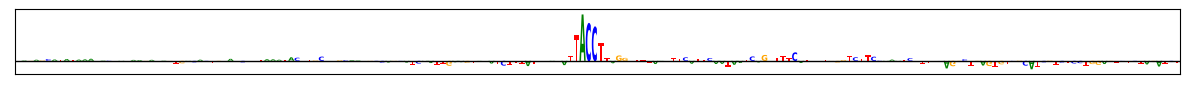

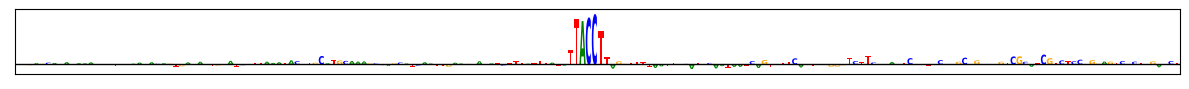

liver


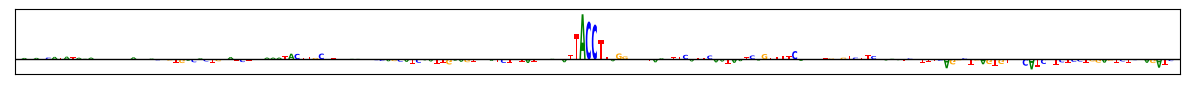

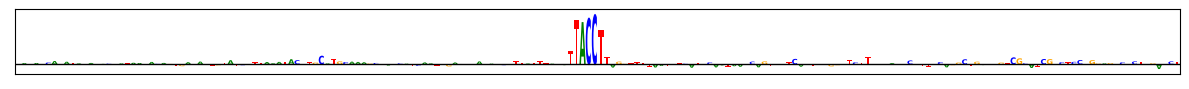

muscle


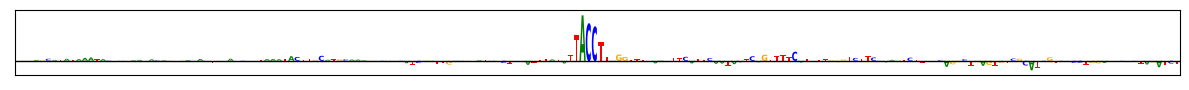

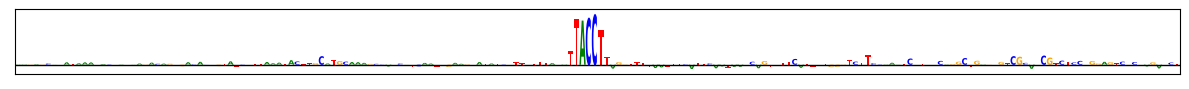

In [6]:
#Enumerate and visualize attributions (relative fold changes)

top_n = 10

r_vals = np.zeros((scores.shape[1], scores.shape[0]))

#Loop over examples
for example_ix in range(scores.shape[1]) :
    
    #Calculate spearman correlation between grad and ISM values
    for tissue_ix in range(len(gtex_tissues)) :
        r_vals[example_ix, tissue_ix] = spearmanr(
            np.sum(scores[tissue_ix, example_ix, ...], axis=-1),
            np.sum(isms[tissue_ix, example_ix, ...], axis=-1),
        )[0]
    
    #Visualize example
    if example_ix < top_n :
        
        print("-- " + str(example_ix) + " (" + str(strands[example_ix]) + ") --")

        print(tissue_genes[example_ix])
        print(chrs[example_ix] + ":" + str(starts[example_ix]) + "-" + str(ends[example_ix]))

        #Compare contribution scores
        for tissue_ix in range(len(gtex_tissues)) :

            score = scores[tissue_ix, example_ix, ...]
            ism = isms[tissue_ix, example_ix, ...]

            f = plt.figure(figsize=(3, 3))

            plt.scatter(np.sum(score, axis=-1), np.sum(ism, axis=-1), s=8, color='black', alpha=0.1)

            plt.xlabel("Grad score (" + gtex_tissues[tissue_ix] + ")", fontsize=8)
            plt.ylabel("ISM score (" + gtex_tissues[tissue_ix] + ")", fontsize=8)
            
            plt.xticks(fontsize=8)
            plt.yticks(fontsize=8)
            
            plt.title(gtex_tissues[tissue_ix] + ", r = " + str(round(r_vals[example_ix, tissue_ix], 2)), fontsize=8)

            plt.tight_layout()

            plt.show()

        #Visualize contribution scores
        for tissue_ix in range(len(gtex_tissues)) :

            print(gtex_tissues[tissue_ix])

            score = scores[tissue_ix, example_ix, :, :]
            ism = isms[tissue_ix, example_ix, :, :]

            plot_seq_scores(
                score,
                figsize=(12, 1),
                plot_y_ticks=False,
            )

            plot_seq_scores(
                ism,
                figsize=(12, 1),
                plot_y_ticks=False,
            )


blood median r = 0.69
brain median r = 0.69
esophagus median r = 0.71
liver median r = 0.7
muscle median r = 0.7


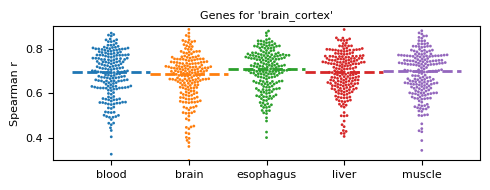

In [7]:
#Visualize tissue-specific distributions of contribution score correlations (grad vs. ISM)

save_figs = True

f = plt.figure(figsize=(1 * len(gtex_tissues), 2))

sns.swarmplot(data=r_vals.T.tolist(), s=2)

#Loop over tissues
for tissue_i, gtex_tissue in enumerate(gtex_tissues) :
    median_r = np.median(r_vals[:, tissue_i])
    
    print(gtex_tissue + " median r = " + str(round(median_r, 2)))
    
    plt.plot([tissue_i - 0.5, tissue_i + 0.5], [median_r, median_r], linestyle='--', linewidth=2)

plt.xticks(np.arange(len(gtex_tissues)), gtex_tissues, fontsize=8)
plt.yticks(fontsize=8)

plt.ylabel("Spearman r", fontsize=8)

plt.ylim(0.3, 0.9)

plt.title("Genes for '" + tissue + "'", fontsize=8)

plt.tight_layout()

if save_figs :
    plt.savefig("gtex_diff_expr_grad_vs_ism_corrs_" + tissue + ".eps")
    plt.savefig("gtex_diff_expr_grad_vs_ism_corrs_" + tissue + ".png", dpi=300, transparent=False)

plt.show()
